<a href="https://colab.research.google.com/github/aarondelgiudice/thinkful_data_bootcamp/blob/master/unit_4/lesson_2/4_2_5_Challenge_Boston_Marathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge: Boston marathon
Unit 4 / Lesson 2 / Project 5

You now have a pretty varied suite of clustering and clustering evaluation methods, let's try them out on some real data.

There is a lot of information on [runners and their performance for the Boston Marathon](https://github.com/llimllib/bostonmarathon).
Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data.
Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters.

Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [0]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift
from sklearn.cluster import estimate_bandwidth, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

## Import Data

In [2]:
PATH = ("https://raw.githubusercontent.com/llimllib/"
        "bostonmarathon/master/results/2013/results.csv")
raw_data = pd.read_csv(PATH)
df_raw = pd.DataFrame(raw_data)
df_raw.head()

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


## Context
Data on the Boston Marathon available from baa.org

## EDA

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 21 columns):
25k          16164 non-null object
age          16164 non-null int64
name         16164 non-null object
division     16164 non-null int64
10k          16164 non-null object
gender       16164 non-null object
half         16164 non-null object
official     16164 non-null float64
bib          16164 non-null object
ctz          757 non-null object
country      16164 non-null object
overall      16164 non-null int64
pace         16164 non-null float64
state        14701 non-null object
30k          16164 non-null object
5k           16164 non-null object
genderdiv    16164 non-null int64
20k          16164 non-null object
35k          16164 non-null object
city         16163 non-null object
40k          16164 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 2.6+ MB


In [4]:
df_raw.describe()

,age,division,official,overall,pace,genderdiv
count,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000
mean,41.638332,1100.967025,208.159470,8429.373422,7.947398,4351.684732
std,10.351311,942.114816,23.743608,5052.024116,0.905739,2772.398239
min,18.000000,1.000000,85.530000,1.000000,3.270000,1.000000
25%,34.000000,363.000000,191.727500,4061.750000,7.320000,2032.750000
50%,42.000000,842.000000,209.225000,8247.500000,7.980000,4113.500000
75%,49.000000,1560.000000,225.230000,12662.250000,8.600000,6316.000000
max,80.000000,3834.000000,284.230000,17598.000000,10.850000,10648.000000


In [5]:
# Remove '-' from all columns

def non_decimal(x):
    x = str(x)
    if x.find('-') != -1:
        return np.nan
    else:
        return float(x)

df_raw['5k'] = df_raw['5k'].apply(non_decimal)    
df_raw['10k'] = df_raw['10k'].apply(non_decimal)
df_raw['20k'] = df_raw['20k'].apply(non_decimal)
df_raw['25k'] = df_raw['25k'].apply(non_decimal)
df_raw['half'] = df_raw['half'].apply(non_decimal)
df_raw['30k'] = df_raw['30k'].apply(non_decimal)
df_raw['35k'] = df_raw['35k'].apply(non_decimal)
df_raw['40k'] = df_raw['40k'].apply(non_decimal)
df_raw['official'] = df_raw['official'].apply(non_decimal)

display(df_raw.head(5))

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


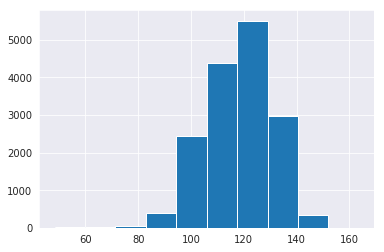

In [6]:
df_raw['25k'].hist()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


<Figure size 432x288 with 0 Axes>

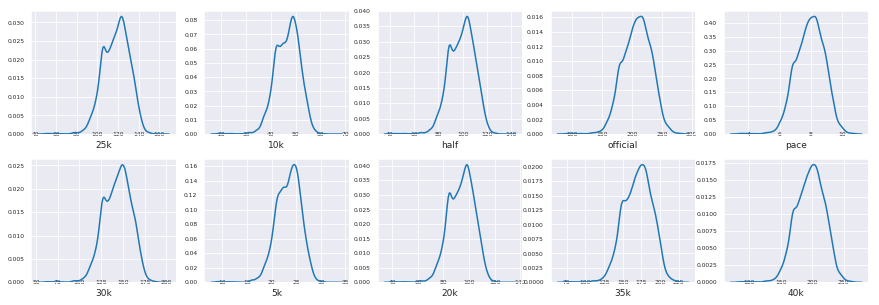

In [7]:
def plot_feature_distribution(df, features):
    i = 0
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(15,5))

    for feature in features:
        i += 1
        plt.subplot(2,5,i)
        sns.distplot(df[feature], hist=False)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();
    
features = df_raw.dtypes[df_raw.dtypes == 'float64'].index
plot_feature_distribution(df_raw, features)

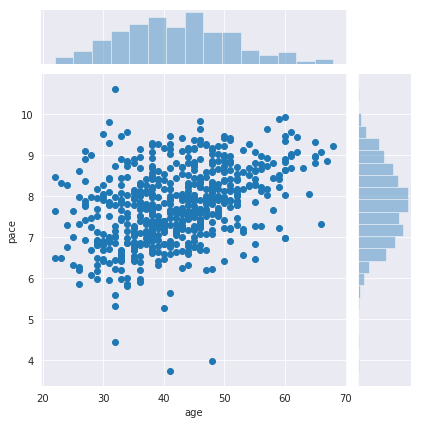

In [8]:
#Age/Gender vs. Pace
sns.jointplot(x="age", y="pace", data=df_raw.dropna())
plt.show()

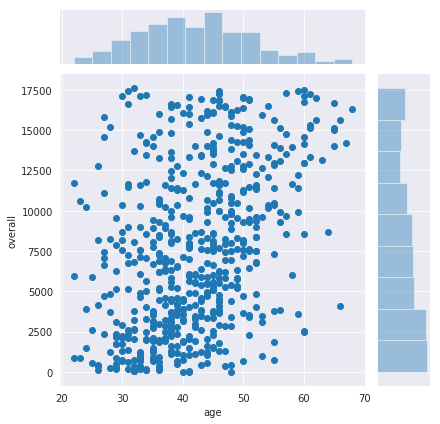

In [9]:
#Age vs. Overall
sns.jointplot(x="age", y="overall", data=df_raw.dropna())
plt.show()

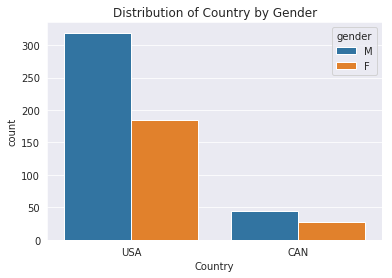

In [10]:
#Countplot of country with gender

sns.countplot(x='country', hue='gender', data=df_raw.dropna())
plt.title('Distribution of Country by Gender')
plt.xlabel('Country')
plt.show()

## Data Cleaning

In [11]:
# view sum of NaN values
df_raw.isna().sum()#.sum()

25k             23
age              0
name             0
division         0
10k             26
gender           0
half            16
official         0
bib              0
ctz          15407
country          0
overall          0
pace             0
state         1463
30k             17
5k              66
genderdiv        0
20k             17
35k             21
city             1
40k             17
dtype: int64

In [12]:
categorical = df_raw.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

name
16137
gender
2
bib
16157
ctz
75
country
68
state
65
city
4416


In [0]:
# drop features with too many unique values
drop_list = ['name', 'bib', 'ctz', 'city', 'country', 'gender', 'state']
df_raw = df_raw.drop(drop_list, axis=1)

In [0]:
# drop NaNs
df_raw = df_raw.dropna()

In [15]:
# normalize data
cols = df_raw.columns
df_raw = normalize(df_raw)
df_raw = pd.DataFrame(df_raw, columns=cols)
df_raw.head()

,25k,age,division,10k,half,official,overall,pace,30k,5k,genderdiv,20k,35k,40k
0,0.278194,0.156195,0.050205,0.101415,0.228323,0.507075,0.050205,0.019357,0.346250,0.049648,0.050205,0.216441,0.416873,0.477231
1,0.292522,0.113571,0.018929,0.116978,0.245692,0.501606,0.018929,0.019194,0.351957,0.060193,0.018929,0.232897,0.411809,0.472343
2,0.295174,0.087906,0.003822,0.118100,0.248125,0.498276,0.003822,0.019034,0.354377,0.060885,0.003822,0.235169,0.415377,0.473089
3,0.285353,0.180818,0.028253,0.105835,0.237323,0.499678,0.028253,0.019099,0.346661,0.050742,0.028253,0.225344,0.412490,0.471425
4,0.279060,0.223248,0.017173,0.104068,0.232235,0.499274,0.017173,0.019062,0.343001,0.051061,0.017173,0.220672,0.410318,0.468706


In [0]:
# store clean data
df_clean = df_raw

## Correlation Matrix

In [17]:
corr_mat = df_clean.corr()
corr_mat

,25k,age,division,10k,half,official,overall,pace,30k,5k,genderdiv,20k,35k,40k
25k,1.000000,0.939211,0.261545,0.999552,0.999976,0.999484,-0.705099,0.999484,0.999875,0.998709,-0.050478,0.999975,0.999633,0.999587
age,0.939211,1.000000,0.141069,0.933605,0.938181,0.941762,-0.681976,0.941782,0.940853,0.929966,-0.028383,0.938271,0.942344,0.941554
division,0.261545,0.141069,1.000000,0.265146,0.262242,0.260968,-0.494295,0.260946,0.260462,0.266559,0.234738,0.262161,0.259640,0.261182
10k,0.999552,0.933605,0.265146,1.000000,0.999707,0.998475,-0.704056,0.998477,0.999097,0.999693,-0.047891,0.999700,0.998582,0.998615
half,0.999976,0.938181,0.262242,0.999707,1.000000,0.999322,-0.704861,0.999322,0.999779,0.998947,-0.049923,0.999999,0.999474,0.999436
official,0.999484,0.941762,0.260968,0.998475,0.999322,1.000000,-0.707278,0.999999,0.999761,0.997408,-0.050297,0.999330,0.999899,0.999986
overall,-0.705099,-0.681976,-0.494295,-0.704056,-0.704861,-0.707278,1.000000,-0.707279,-0.705548,-0.703342,-0.608422,-0.704865,-0.706163,-0.706938
pace,0.999484,0.941782,0.260946,0.998477,0.999322,0.999999,-0.707279,1.000000,0.999760,0.997411,-0.050310,0.999330,0.999898,0.999985
30k,0.999875,0.940853,0.260462,0.999097,0.999779,0.999761,-0.705548,0.999760,1.000000,0.998084,-0.051270,0.999785,0.999914,0.999841
5k,0.998709,0.929966,0.266559,0.999693,0.998947,0.997408,-0.703342,0.997411,0.998084,1.000000,-0.046841,0.998935,0.997452,0.997550


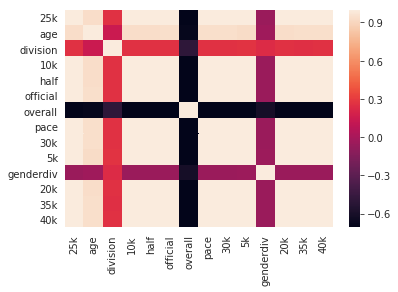

In [18]:
sns.heatmap(corr_mat)
plt.show()

## Training Split

In [0]:
data = df_clean
features = [c for c in df_clean.columns]

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data, test_size=0.5, random_state=42)

## K-Means

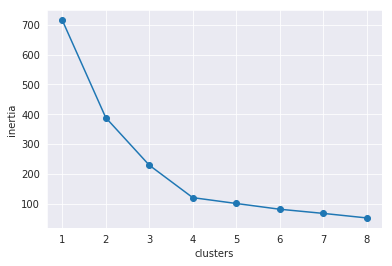

In [20]:
# Find optimal K
# Intertias
ks = range(1, 9)
inertias = []

for k in ks:
    # Instantiate and fit model
    model = KMeans(n_clusters=k, random_state=42).fit(X_train)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('clusters')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [21]:
# objects with a silhouette index close to 1 are considered well clustered
# refit model with optimal K
model = KMeans(n_clusters=3, random_state=42).fit(X_train)

# extract cluster assignments for each data point
X_train['kmeans_labels'] = model.labels_

# find size of each cluster
print(X_train['kmeans_labels'].value_counts())

# view silhouette score
print('Silhouette score:', silhouette_score(
    X_train, X_train['kmeans_labels'], metric='euclidean'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0    3287
2    3253
1    1487
Name: kmeans_labels, dtype: int64
Silhouette score: 0.857759206234917


In [22]:
# Test results
km_sil_scores = []

print('K-Means silhouette scores of train/test data:')
for sample in [X_train, X_test]:
  model = KMeans(n_clusters=3, random_state=42).fit(sample)
  labels = model.labels_
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  km_sil_scores.append(sil_score)
  print(sil_score)
    
# view variance
variances = {}
variances['K-means'] = np.var(km_sil_scores)
print('variance:', variances['K-means'])

K-Means silhouette scores of train/test data:
0.857759206234917
0.5973042642566425
variance: 0.01695919420022658


## Mean-Shift

In [23]:
# Set bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.3)

# Instantiate and fit the model.
model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X_train)

# Extract cluster assignments for each data point.
X_train['mean_shift_labels'] = model.labels_
display(X_train['mean_shift_labels'].value_counts())

# Coordinates of the cluster centers.
cluster_centers = model.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(model.labels_))
print("Number of estimated clusters: {}".format(n_clusters_))

# Silhouette score
print('Silhouette score:', silhouette_score(
    X_train, X_train['mean_shift_labels'], metric='euclidean'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0    3287
1    3253
2    1344
3     143
Name: mean_shift_labels, dtype: int64

Number of estimated clusters: 4
Silhouette score: 0.913808979092396


In [24]:
# Test results
ms_sil_scores = []

print('Mean Shift silhouette scores of train/test data:')
for sample in [X_train, X_test]:
  # estimate bandwidth
  bandwidth = estimate_bandwidth(sample, quantile=0.3)
  # Instantiate and fit model
  model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample)
  # Extract clusters for each data point
  labels = model.labels_
  # Coordinates of cluster centers
  cluster_centers = model.cluster_centers_
  # Count clusters
  n_clusters_ = len(np.unique(labels))
  
  print('Number of estimate clusters: {}'.format(n_clusters_))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  ms_sil_scores.append(sil_score)
  print(sil_score)
    
# view variance
print('variance:', np.var(ms_sil_scores))

# view variance
variances['Mean shift'] = np.var(ms_sil_scores)
print('variance:', variances['Mean shift'])

Mean Shift silhouette scores of train/test data:
Number of estimate clusters: 4
0.913808979092396
Number of estimate clusters: 4
0.6259525584339208
variance: 0.02071532972857725
variance: 0.02071532972857725


## Spectral Clustering

In [25]:
# Test results
sc_sil_scores = []

print('Spectral clustering silhouette scores of train/test data:')
for sample in [X_train, X_test]:
  # Instantiate and fit model
  model = SpectralClustering(n_clusters=3, random_state=42).fit(sample)
  # Extract clusters for each data point
  labels = model.labels_
  # Count clusters
  n_clusters_ = len(np.unique(labels))
  
  print('Number of estimate clusters: {}'.format(n_clusters_))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  sc_sil_scores.append(sil_score)
  print(sil_score)
    
# view variance
variances['Spectral Clustering'] = np.var(sc_sil_scores)
print('variance:', variances['Spectral Clustering'])

Spectral clustering silhouette scores of train/test data:
Number of estimate clusters: 3
0.9014607720676091
Number of estimate clusters: 3
0.5434258915011189
variance: 0.03204724392556523


## Analysis

In [31]:
for variance in variances.items():
  print(variance)
  
print(np.min(variances.values()))

('K-means', 0.01695919420022658)
('Mean shift', 0.02071532972857725)
('Spectral Clustering', 0.03204724392556523)
dict_values([0.01695919420022658, 0.02071532972857725, 0.03204724392556523])


In [42]:
print('{}, has the lowest variance of {}'.format(
    min(variances, key=variances.get),
    variances[min(variances, key=variances.get)]))

K-means, has the lowest variance of 0.01695919420022658


# Conclusion
Out of the three clustering models tested -- K-means, Mean Shift, and Spectral Clustering -- K-means performed the best. It had the lowest variance and clustered the data into three groups.